1. 데이터 불러오기/변환
2. Overview
  + [ ] 수집 체널 List
3. 당월자료 Summary : Graph
  + [ ] 유형별 수집자료 : 수치, 비율, 전월대비 증/감율
  + [x] Trend
  + [x] 비율
  + [ ] Wordcloud(A/B/C) : color 설정
  + [ ] 연관단어(keyword 기준)
3. 이메일 양식 작성

In [15]:
# DB접속
import pymysql
import pandas as pd
import numpy as np
import os

# 한글정제 KoNLPy
from ckonlpy.tag import Twitter
twitter = Twitter()

# 그래프
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
path = 'C:/windows/Fonts/malgun.ttf'                           # 폰트:맑은고딕
font_name = fm.FontProperties(fname=path, size=24).get_name()  
plt.rc('font', family=font_name)
from matplotlib.font_manager import FontProperties

prop = FontProperties(fname='/System/Library/Fonts/Apple Color Emoji.ttc')
plt.rcParams['font.family'] = prop.get_family()

# 시간기록
from datetime import datetime, timedelta
import time 

# 내용공유(e-mail, 회사) 
# import send_email as se
from jinja2 import Template

import warnings
warnings.filterwarnings("ignore")

### I.데이터 불러오기

In [4]:
df_new = pd.read_excel('./kakaomakers.xlsx',0)

# 날자 타입 변경
df_new['DATE'] = pd.to_datetime(df_new['DATE'])
df_new['DATE'] = df_new['DATE'].dt.strftime('%m/%d')

# 날짜기준 정렬
df_new.sort_values(by=['DATE'], inplace=True, ascending=False)

# 상품 정렬
product_list = ['[매일유업] 소화가 잘되는 우유 국산 5곡 미숫가루 190ml x 24팩',
                '매일유업 소화가 잘되는 우유 국산 5곡 미숫가루 190ml x 24팩' ]

category_list = ['소잘 미숫가루',
                 '소잘 미숫가루']

df_category = pd.DataFrame({'PRODUCT' : product_list, 'CATEGORY' :category_list})

# merge
df_new = df_new.join(df_category.set_index('PRODUCT')['CATEGORY'], on='PRODUCT')
df_new = df_new[df_new.columns[1:]]

df_new['TEXT'] = df_new['TEXT'].str.replace('\n', ' ')


# 자료 분리
df_QnA    = df_new[df_new['GUBUN']=='문의']
df_review = df_new[df_new['GUBUN']=='제품후기']

In [12]:
df_review = df_review.dropna().reset_index()

In [14]:
df_review.tail(2)

,level_0,index,USER,PRODUCT,TEXT,DATE,SCORE,CHANNEL,GUBUN,CATEGORY
798,798,346,허사장님,[매일유업] 소화가 잘되는 우유 국산 5곡 미숫가루 190ml x 24팩,주문하고 먹어보고 싶어서 너무 기다렸는데 오늘 왔네요! 배송온거 뜯자마자 한팩 마시...,08/03,4.0,카카오메이커스,제품후기,소잘 미숫가루
799,799,1139,김희정,[매일유업] 소화가 잘되는 우유 국산 5곡 미숫가루 190ml x 24팩,유통기한이 10/30,08/03,1.0,카카오메이커스,제품후기,소잘 미숫가루


In [16]:
###############
# Text 정제
#####

# 사전에 고유 명사 추가
twitter.add_dictionary('셀렉스', 'Noun')
twitter.add_dictionary('어메이징', 'Noun')
twitter.add_dictionary('오트', 'Noun')
twitter.add_dictionary('어메이징 오트', 'Noun')
twitter.add_dictionary('무설탕', 'Noun')
twitter.add_dictionary('프로틴', 'Noun')
twitter.add_dictionary('보냉백', 'Noun')
twitter.add_dictionary('라방', 'Noun')
twitter.add_dictionary('재구매', 'Noun')
twitter.add_dictionary('유통기한', 'Noun')
twitter.add_dictionary('사은품', 'Noun')
twitter.add_dictionary('팥빙수', 'Noun')
twitter.add_dictionary('의향', 'Noun')


def tokenize(doc):
    result = ['/'.join(t) for t in twitter.pos(doc, norm=True, stem=True)] # ex '더빙/Norm', '나다/Verb'
    return result 

def listToString(s):  
    str1 = ""  
    for ele in s:  
        str1 += " " + ele.strip()  
    return str1


In [19]:
#토큰화 : 전체리뷰자료
df_temp1 = df_review['TEXT'].replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")

# regex to konlpy
token_all = [tokenize(row) for row in df_temp1 ]  

data_trim2 = []
for i in range(len(df_temp1)):
    t = ' '.join(token_all[i])
    data_trim2.append(t.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]",""))
    
df_temp1 = pd.DataFrame(data_trim2)
df_temp1 = df_temp1[0].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")

df_review['token'] = df_temp1
df_review['token_attribution'] = token_all



In [20]:
df_review.tail(2)

,level_0,index,USER,PRODUCT,TEXT,DATE,SCORE,CHANNEL,GUBUN,CATEGORY,token,token_attribution
798,798,346,허사장님,[매일유업] 소화가 잘되는 우유 국산 5곡 미숫가루 190ml x 24팩,주문하고 먹어보고 싶어서 너무 기다렸는데 오늘 왔네요! 배송온거 뜯자마자 한팩 마시...,08/03,4.0,카카오메이커스,제품후기,소잘 미숫가루,주문 하고 먹다 어보 고 싶다 어서 너무 기다리다 오늘 오다 배송 오다 뜯다 자마...,"[주문/Noun, 하고/Josa, 먹다/Verb, 어보/Noun, 고/Josa, 싶..."
799,799,1139,김희정,[매일유업] 소화가 잘되는 우유 국산 5곡 미숫가루 190ml x 24팩,유통기한이 10/30,08/03,1.0,카카오메이커스,제품후기,소잘 미숫가루,유통기한 이,"[유통기한/Noun, 이/Josa, 10/30/Number]"


In [22]:
# Excel 자료 저장 v2
now = datetime.today()    # 현재
date = now.strftime('%Y%m%d')

writer = pd.ExcelWriter('./'+ date+ '_kakaomakers.xlsx')
df_review.to_excel(writer, 'Sheet1')
writer.save()

In [4]:
report_channel = df_review['CHANNEL'].unique()
report_porduct = df_review['CATEGORY'].unique()

def report_head(category_text, gubun_text):
    report_temp = df_new[(df_new['CATEGORY'] ==category_text) & (df_new['GUBUN'] ==gubun_text) ].head(10)
    report_temp = report_temp[['USER', 'DATE', 'CHANNEL', 'TEXT', 'SCORE']]
    report_temp['SCORE'] = report_temp['SCORE'].fillna('-')
    return report_temp

def report_head_neg(category_text, gubun_text):
    report_temp = df_new[(df_new['CATEGORY'] ==category_text) & (df_new['GUBUN'] ==gubun_text) ]
    report_temp = report_temp[report_temp['SCORE'] <=2].head(10)
    report_temp = report_temp[['USER', 'DATE', 'CHANNEL', 'TEXT', 'SCORE']]
    report_temp['SCORE'] = report_temp['SCORE'].fillna('-')
    return report_temp

def report_head_pos(category_text, gubun_text):
    report_temp = df_new[(df_new['CATEGORY'] ==category_text) & (df_new['GUBUN'] ==gubun_text) ]
    report_temp = report_temp[report_temp['SCORE'] >=3].head(10)
    report_temp = report_temp[['USER', 'DATE', 'CHANNEL', 'TEXT', 'SCORE']]
    report_temp['SCORE'] = report_temp['SCORE'].fillna('-')
    return report_temp


def report_trend(category_text, image_name):
    report_temp = df_new[(df_new['CATEGORY'] ==category_text) ]
    report_temp = report_temp[['USER', 'DATE', 'CATEGORY', 'GUBUN']]
    
    fig = plt.figure(figsize=(7, 4))
    ax = plt.subplot(1,1,1)
    report_temp.pivot_table(values='USER', index=['DATE'], columns='GUBUN', aggfunc='count').plot.bar(stacked=True, ax = ax)
    plt.legend(loc='best', fancybox=True, shadow=True, ncol=1)
    plt.title('{} : 작성 추이'.format(category_text),fontsize=15)
    plt.ylabel('작성 건 수')
    plt.savefig(image_name, bbox_inches='tight', dpi=70)
    return

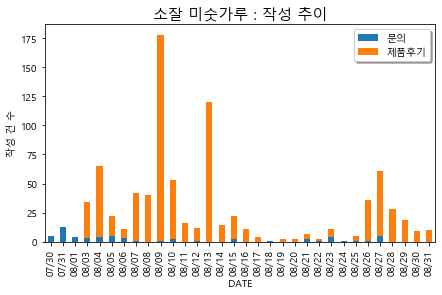

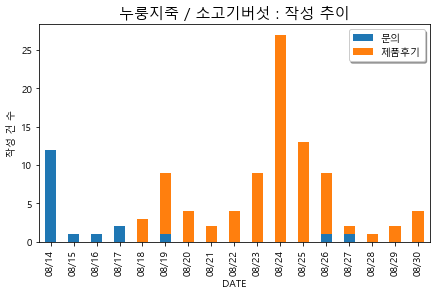

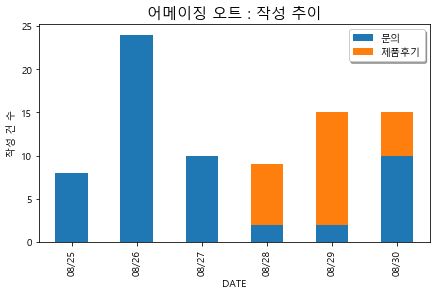

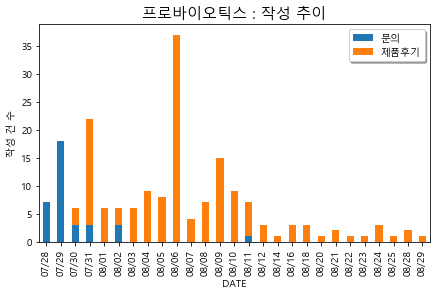

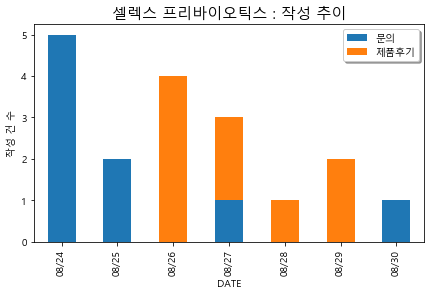

In [6]:
REPORT_01_RVW = report_head('소잘 미숫가루', '제품후기')
REPORT_01_NEG = report_head_neg('소잘 미숫가루', '제품후기')
REPORT_01_POS = report_head_pos('소잘 미숫가루', '제품후기')
REPORT_01_QNA = report_head('소잘 미숫가루', '문의')
REPORT_01     = report_trend('소잘 미숫가루', 'VoC_REPORT_01.png')

REPORT_02_RVW = report_head('누룽지죽 / 소고기버섯', '제품후기')
REPORT_02_NEG = report_head_neg('누룽지죽 / 소고기버섯', '제품후기')
REPORT_02_POS = report_head_pos('누룽지죽 / 소고기버섯', '제품후기')
REPORT_02_QNA = report_head('누룽지죽 / 소고기버섯', '문의')
REPORT_02     = report_trend('누룽지죽 / 소고기버섯', 'VoC_REPORT_02.png')

REPORT_03_RVW = report_head('어메이징 오트', '제품후기')
REPORT_03_NEG = report_head_neg('어메이징 오트', '제품후기')
REPORT_03_POS = report_head_pos('어메이징 오트', '제품후기')
REPORT_03_QNA = report_head('어메이징 오트', '문의')
REPORT_03     = report_trend('어메이징 오트', 'VoC_REPORT_03.png')

REPORT_04_RVW = report_head('프로바이오틱스', '제품후기')
REPORT_04_NEG = report_head_neg('프로바이오틱스', '제품후기')
REPORT_04_POS = report_head_pos('프로바이오틱스', '제품후기')
REPORT_04_QNA = report_head('프로바이오틱스', '문의')
REPORT_04     = report_trend('프로바이오틱스', 'VoC_REPORT_04.png')

REPORT_05_RVW = report_head('셀렉스 프리바이오틱스', '제품후기')
REPORT_05_NEG = report_head_neg('셀렉스 프리바이오틱스', '제품후기')
REPORT_05_POS = report_head_pos('셀렉스 프리바이오틱스', '제품후기')
REPORT_05_QNA = report_head('셀렉스 프리바이오틱스', '문의')
REPORT_05     = report_trend('셀렉스 프리바이오틱스', 'VoC_REPORT_05.png')


In [182]:
category_text = '소잘 미숫가루'
report_temp = df_new[(df_new['CATEGORY'] ==category_text) ]
report_temp = report_temp[['USER', 'DATE', 'CATEGORY', 'GUBUN']]

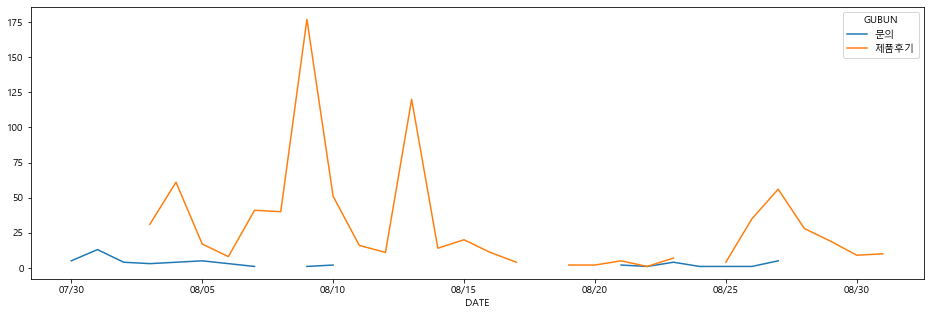

In [195]:
report_temp.pivot_table(values='USER', index=['DATE'], columns='GUBUN', aggfunc='count').plot()

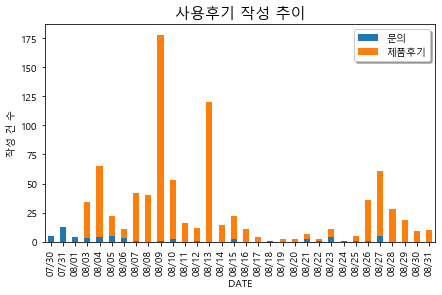

In [206]:
fig = plt.figure(figsize=(7, 4))
ax = plt.subplot(1,1,1)
report_temp.pivot_table(values='USER', index=['DATE'], columns='GUBUN', aggfunc='count').plot.bar(stacked=True, ax = ax)
plt.legend(loc='best', fancybox=True, shadow=True, ncol=1)
plt.title('사용후기 작성 추이',fontsize=15)
plt.ylabel('작성 건 수')
plt.show()

In [93]:
report_head('매일유업 셀렉스 썬화이버 프리바이오틱스 125g (12.5g x 10개입)', '문의')

,USER,DATE,CHANNEL,TEXT,SCORE
0,spring,08/30,카카오메이커스,물에 타먹으라고 하였는데 찬물에도 잘 녹는지 여부와 꼭 물에 타먹어야 되는지 등 \...,-
1,meon,08/27,카카오메이커스,콤부차에 타서먹어도 되나요?,-
2,지운,08/25,카카오메이커스,꼭물에타서먹어야하나요?다른분말형유산균처럼복용해도되나요?,-
3,양정호,08/25,카카오메이커스,"식후혈당 억제에 대한,제품의 설명이 부족해 보입니다.\n좀 더 자세히 설명 부탁드립...",-
4,jieun,08/24,카카오메이커스,이제품 프로바이오틱스랑 같이먹어도 되나요,-
5,이정희,08/24,카카오메이커스,유산균은 위산에 약하기 때문에 음식과 같이 먹으면 안된다고 알고있는데 이 제품은 샐...,-
6,mina,08/24,카카오메이커스,10회 먹을수있는 분량인거에요?\n적정복욕량은 하루에 한번인가요?,-
7,mina,08/24,카카오메이커스,이거 저번에나온거 그거 개별포장되어서 나온거맞죠?,-
8,크롬,08/24,카카오메이커스,지난번에 카카오 메이커스에서 팔았던 깡통에 들어있는걸로 구매해서 먹었는데 좋아서 이...,-


In [148]:
report_head('소잘 미숫가루', '문의')

,USER,DATE,CHANNEL,TEXT,SCORE
45,김캔지,08/27,카카오메이커스,오늘 주문했습니다.\n유통기한 언제까지인가요?,-
44,어피치,08/27,카카오메이커스,생각보다 유통기한이 짧아서 ㅠ 3박스를 두고 먹기가 부담되네요 이렇게 짫을꺼라 생각...,-
48,이다애,08/27,카카오메이커스,다음 판매예정은 언제인지 알수잇을까요?? \n이번에 하나 시켜서 맘에드는데 다음 판...,-
47,김민희,08/27,카카오메이커스,지금 주문했는데 유통기한긴걸로 제품 잘 보내주세용 한달이하로 짧으면 안될거같아요ㅠㅠ,-
46,권선희,08/27,카카오메이커스,유효기간 긴걸로 주세요,-
49,근이,08/26,카카오메이커스,최근 생산된 하자없는 최상의 상품으로 급배송 부탁드립니다,-
50,도보람,08/25,카카오메이커스,24x2개 주문했는데 제주도라서 배송이 조금 걱정이 되네요ㅠㅠㅠ 꼼꼼히 잘 부탁드려요!!,-
51,예솔,08/24,카카오메이커스,안녕하세요\n정보 보니 정제수가 제일 많이 들어간 것 같은데\n원유는 얼마나 들어있...,-
53,서은영,08/23,카카오메이커스,유당0프로에 락토리면 우유가 안들어간건가요??\n우유가 안맞는 체질이라 괜찮을까요???,-
55,섹시희재,08/23,카카오메이커스,우유를 먹으면 설사를 하는데 설사나 그런거는 없겠죠?\n먹고나서 혹시라도 안좋을까봐...,-


In [134]:
# df_QnA.pivot_table(values='USER', index=['DATE'], columns='CHANNEL', aggfunc='count')

In [7]:

#폴더 내용 불러오기
from glob import glob
import os 
path = ''
list_of_images = glob(os.path.join(path, "VoC_REPORT_*.png") )


In [19]:
###############
# Text 정제
#####

# 사전에 고유 명사 추가
twitter.add_dictionary('셀렉스', 'Noun')
twitter.add_dictionary('무설탕', 'Noun')
twitter.add_dictionary('프로틴', 'Noun')
twitter.add_dictionary('보냉백', 'Noun')
twitter.add_dictionary('라방', 'Noun')
twitter.add_dictionary('재구매', 'Noun')
twitter.add_dictionary('유통기한', 'Noun')
twitter.add_dictionary('사은품', 'Noun')
twitter.add_dictionary('언스위트', 'Noun')
twitter.add_dictionary('팥빙수', 'Noun')

def tokenize(doc):
    result = ['/'.join(t) for t in twitter.pos(doc, norm=True, stem=True)] # ex '더빙/Norm', '나다/Verb'
    return result 

def listToString(s):  
    str1 = ""  
    for ele in s:  
        str1 += " " + ele.strip()  
    return str1


In [97]:
#토큰화 : 전체리뷰자료
df_temp1 = df_review_all['문의상세내용'].replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")

# regex to konlpy
token_all = [tokenize(row) for row in df_temp1 ]  

data_trim2 = []
for i in range(len(df_temp1)):
    t = ' '.join(token_all[i])
    data_trim2.append(t.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]",""))
    
df_temp1 = pd.DataFrame(data_trim2)
df_temp1 = df_temp1[0].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")

df_review_all['token'] = df_temp1
df_review_all['token_attribution'] = token_all

In [22]:
df_review_all.head()

,문의내용,문의상세내용,문의등록일,수집채널,category2,token,token_attribution
0,기타,주소변경으로 글 남깁니다1:1도 안되고 어디로 연락드리나요?,08/02,17 카카오 메이커스,음료,주소 변경 으로 글 남기다 도 안되다 어디 로 연락 드 리나 요,"[주소/Noun, 변경/Noun, 으로/Josa, 글/Noun, 남기다/Verb, ..."
1,기타,오리지날만 주문했는데 로우슈거도 같이 오나요?,08/03,17 카카오 메이커스,음료,오리 지 날 만 주문 하다 로우 슈거 도 같이 오다,"[오리/Noun, 지/Josa, 날/Noun, 만/Josa, 주문/Noun, 하다/..."
2,기타,제가 다른 지역에 있어서 이번 배송 건 반품 신청부탁드립니다\n주문 번호 20210...,08/03,26 셀렉스 몰,스포츠RTD,제 가 다른 지역 에 있다 어서 이번 배송 건 반품 신청 부탁 드립 니 다 주문 번...,"[제/Noun, 가/Josa, 다른/Noun, 지역/Noun, 에/Josa, 있다/..."
3,기타,안녕하세요 저분자 가수분해 단백질인가요,08/05,17 카카오 메이커스,음료,안녕 하다 저분자 가수분해 단백질 인가요,"[안녕/Noun, 하다/Verb, 저분자/Noun, 가수분해/Noun, 단백질/No..."
4,기타,이건 고무 끈 같은 게 나왔는 데 이게 뭔가요\n오후 01:12\n이거 조금 먹었는...,08/05,26 셀렉스 몰,스포츠RTD,이건 고무 끈 같다 게 나오다 데 이 게 뭔가 요 오후 이 거 조금 먹다 괜찮다 ...,"[이건/Noun, 고무/Noun, 끈/Noun, 같다/Adjective, 게/Nou..."


In [98]:
##########
#데이터 불리하기
###

# 당월 부정/긍정/중립 리뷰
df_review_gitar   = df_review_all[(df_review_all['문의내용']=='기타')]
df_review_delivery= df_review_all[(df_review_all['문의내용']=='배송')]
df_review_product = df_review_all[(df_review_all['문의내용']=='상품')]


In [68]:
# print('<<기간 내 리뷰수>>' )
# print(' - 긍정(54   ) : {:,.0f}'.format(len(df_review_pos)) )
# print(' - 중립(  3  ) : {:,.0f}'.format(len(df_review_nue)) )
# print(' - 부정(   21) : {:,.0f}'.format(len(df_review_neg)) )

In [69]:
# print('<<기간 내 리뷰수 비중>>' )
# print(' - 긍정(54   ) : {:,.1f}%'.format(len(df_review_pos)/len(df_review_all)*100 ) )
# print(' - 중립(  3  ) : {:,.1f}%'.format(len(df_review_nue)/len(df_review_all)*100 ) )
# print(' - 부정(   21) : {:,.1f}%'.format(len(df_review_neg)/len(df_review_all)*100 ) )

In [25]:
# print('<<기간 내 리뷰 증감률>>' )
# print(' - 전체(54321) : {:,.1f}%'.format( (len(df_review_all)-len(df_review_all_before))/len(df_review_all_before)*100 ) )
# print(' - 긍정(54   ) : {:,.1f}%'.format( (len(df_review_pos)-len(df_review_pos_before))/len(df_review_pos_before)*100 ) )
# print(' - 중립(  3  ) : {:,.1f}%'.format( (len(df_review_nue)-len(df_review_nue_before))/len(df_review_nue_before)*100 ) )
# print(' - 부정(   21) : {:,.1f}%'.format( (len(df_review_neg)-len(df_review_neg_before))/len(df_review_neg_before)*100 ) )

In [26]:
# df_review_neg.head(2)

### III.데이터 리포팅

In [18]:
message_tmpl="""
<html>
    <!DOCTYPE html>
    <html>
    <head lang ="ko">
      <meta charset ="UTF-8">
      <title>{{title1}}</title>
    </head>
    <BODY style="FONT-SIZE: 10pt; font-family: Malgun Gothic, NanumGothic, gulim, sans-serif">
    안녕하세요,<br>
    <br>
    {{send_date}}기준, 신제품 VoC 모니터링 현황 내용 공유드립니다.<br>
    - 채널 : {{channel}}<br>
    - 제품 : {{category}}<br>
    <br>
    <OL>
    <LI>
    <DIV><b>채널 Trend 전반</b></DIV>
    <img src={{ image_file0 }} ><br>
    <LI>
    <DIV><b>[소잘 미숫가루] 제품</b></DIV>
        <OL>
        <LI>
        <DIV>작성 추이</DIV>
        <img src={{ image_file1 }} >
        <LI><DIV>긍정리뷰 : 최근 10개</DIV>
        {{ df1_r_pos_html }}</li>
        <LI><DIV>부정리뷰 : 최근 10개</DIV>
        {{ df1_r_neg_html }}
        <LI><DIV>문의하기 : 최근 10개</DIV>
        {{ df1_Q_html }}
        </LI>
        </OL>
    <LI>
    <DIV><b>[누룽지죽 / 소고기버섯] 제품</b></DIV>
        <OL>
        <LI>
        <DIV>작성 추이</DIV>
        <img src={{ image_file2 }} >
        <LI><DIV>긍정리뷰 : 최근 10개</DIV>
        {{ df2_r_pos_html }}</li>
        <LI><DIV>부정리뷰 : 최근 10개</DIV>
        {{ df2_r_neg_html }}
        <LI><DIV>문의하기 : 최근 10개</DIV>
        {{ df2_Q_html }}
        </LI>
        </OL>
    <LI>
    <DIV><b>[어메이징 오트] 제품</b></DIV>
        <OL>
        <LI>
        <DIV>작성 추이</DIV>
        <img src={{ image_file3 }} >
        <LI><DIV>긍정리뷰 : 최근 10개</DIV><br>
        {{ df3_r_pos_html }}</li>
        <LI><DIV>부정리뷰 : 최근 10개</DIV>
        {{ df3_r_neg_html }}
        <LI><DIV>문의하기 : 최근 10개</DIV>
        {{ df3_Q_html }}
        </LI>
        </OL>
    <LI>
    <DIV><b>[프로바이오틱스] 제품</b></DIV>
        <OL>
        <LI>
        <DIV>작성 추이</DIV>
        <img src={{ image_file4 }} >
        <LI><DIV>긍정리뷰 : 최근 10개</DIV>
        {{ df4_r_pos_html }}</li>
        <LI><DIV>부정리뷰 : 최근 10개</DIV>
        {{ df4_r_neg_html }}
        <LI><DIV>문의하기 : 최근 10개</DIV>
        {{ df4_Q_html }}
        </LI>
        </OL>
    <LI>
    <DIV><b>[셀렉스 프리바이오틱스] 제품</b></DIV>
        <OL>
        <LI>
        <DIV>작성 추이</DIV>
        <img src={{ image_file5 }} >
        <LI><DIV>긍정리뷰 : 최근 10개</DIV>
        {{ df5_r_pos_html }}</li>
        <LI><DIV>부정리뷰 : 최근 10개</DIV>
        {{ df5_r_neg_html }}
        <LI><DIV>문의하기 : 최근 10개</DIV>
        {{ df5_Q_html }}
        </LI>
        </OL>
    </LI>
    </OL>
    </LI>
    </OL>
    <br>
    <br>
    <SPAN style="COLOR: #808080">{{add_text1}}</SPAN><br>
    <SPAN style="COLOR: #808080">{{add_text2}}</SPAN><br>
    <br>
    <br>
    감사합니다.<br>
    <br>
    </BODY>
</html>"""

# 이메일 양식(내용) 변동 내용 정의
render_data = {
    'send_date' : (datetime.today()).strftime('%m/%d'),
    'send_weekday' : (datetime.today()).strftime('%Y, %W')+'주',
    'category' : df_review['CATEGORY'].unique(),
    'channel'  : df_review['CHANNEL'].unique()[0],
#     'image_file0': list_of_images[0],
#     'image_file1': list_of_images[1],
#     'image_file2': list_of_images[2],
#     'image_file3': list_of_images[3],
#     'image_file4': list_of_images[4],
#     'image_file5': list_of_images[5],
    'df1_r_pos_html' : REPORT_01_POS.to_html(index = False),
    'df1_r_neg_html' : REPORT_01_NEG.to_html(index = False),
    'df1_Q_html'     : REPORT_01_QNA.to_html(index = False),
    'df2_r_pos_html' : REPORT_02_POS.to_html(index = False),
    'df2_r_neg_html' : REPORT_02_NEG.to_html(index = False),
    'df2_Q_html'     : REPORT_02_QNA.to_html(index = False),
    'df3_r_pos_html' : REPORT_03_POS.to_html(index = False),
    'df3_r_neg_html' : REPORT_03_NEG.to_html(index = False),
    'df3_Q_html'     : REPORT_03_QNA.to_html(index = False),
    'df4_r_pos_html' : REPORT_04_POS.to_html(index = False),
    'df4_r_neg_html' : REPORT_04_NEG.to_html(index = False),
    'df4_Q_html'     : REPORT_04_QNA.to_html(index = False),
    'df5_r_pos_html' : REPORT_05_POS.to_html(index = False),
    'df5_r_neg_html' : REPORT_05_NEG.to_html(index = False),
    'df5_Q_html'     : REPORT_05_QNA.to_html(index = False),
    'add_text1' : "**  본 메일은 발신전용입니다.",
    'add_text2' : "*** (내용/기술문의 : 고객정보전략담당, 박경하 )"
}

t= Template(message_tmpl)
html_report = t.render(render_data)

In [19]:
html_report

'\n<html>\n    <!DOCTYPE html>\n    <html>\n    <head lang ="ko">\n      <meta charset ="UTF-8">\n      <title></title>\n    </head>\n    <BODY style="FONT-SIZE: 10pt; font-family: Malgun Gothic, NanumGothic, gulim, sans-serif">\n    안녕하세요,<br>\n    <br>\n    09/03기준, 신제품 VoC 모니터링 현황 내용 공유드립니다.<br>\n    - 채널 : 카카오메이커스<br>\n    - 제품 : [\'소잘 미숫가루\' \'누룽지죽 / 소고기버섯\' \'어메이징 오트\' \'프로바이오틱스\' \'셀렉스 프리바이오틱스\']<br>\n    <br>\n    <OL>\n    <LI>\n    <DIV><b>채널 Trend 전반</b></DIV>\n    <img src= ><br>\n    <LI>\n    <DIV><b>[소잘 미숫가루] 제품</b></DIV>\n        <OL>\n        <LI>\n        <DIV>작성 추이</DIV>\n        <img src= >\n        <LI><DIV>긍정리뷰 : 최근 10개</DIV>\n        <table border="1" class="dataframe">\n  <thead>\n    <tr style="text-align: right;">\n      <th>USER</th>\n      <th>DATE</th>\n      <th>CHANNEL</th>\n      <th>TEXT</th>\n      <th>SCORE</th>\n    </tr>\n  </thead>\n  <tbody>\n    <tr>\n      <td>하진</td>\n      <td>08/31</td>\n      <td>카카오메이커스</td>\n      <td>부모님댁에도 같이 시켰는데 좋아하시네요

In [101]:
trend_review_all = pd.pivot_table(df_review_all, index = '문의등록일', values = '문의상세내용', columns = '문의내용', aggfunc = 'count').fillna(0)

trend_gitar = pd.pivot_table(df_review_gitar, index = '문의등록일', values = '문의상세내용', aggfunc = 'count').fillna(0)
trend_delivery = pd.pivot_table(df_review_delivery, index = '문의등록일', values = '문의상세내용', aggfunc = 'count').fillna(0)
trend_product = pd.pivot_table(df_review_product, index = '문의등록일', values = '문의상세내용', aggfunc = 'count').fillna(0)
